In [1]:
import csv
import ray
import sys
import pandas as pd

FILE = "../task3/wiki.txt"
csv.field_size_limit(sys.maxsize)
ray.init()

2023-11-14 09:31:52,743	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.4.0


In [2]:
def read_file(filename):
    schema = {
        'url': str,
        'title': str,
        'text': str
    }
    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        return pd.read_csv(f, sep='\t', names=list(schema.keys())[:3], dtype=schema, header=None, on_bad_lines='skip')


In [3]:
df = read_file(FILE)
df.head()

,url,title,text
0,http://ru.wikipedia.org/wiki?curid=7,Литва,"Литва Литва́ (), официальное название — Лито́..."
1,http://ru.wikipedia.org/wiki?curid=9,Россия,Россия Росси́я (от — Русь; официально Росси́...
2,http://ru.wikipedia.org/wiki?curid=10,Слоновые,Слоновые Слоно́вые () — семейство млекопитающ...
3,http://ru.wikipedia.org/wiki?curid=11,Мамонты,Мамонты Ма́монты () — вымерший род млекопитаю...
4,http://ru.wikipedia.org/wiki?curid=15,Красная книга,Красная книга Первая организационная задача о...


In [4]:
%%time

import re
from collections import Counter

normalized_words = {}

@ray.remote
def process_text (text):
    processed_text = []
    # latin_words = []
    urllles = re.sub(r"http\S+|www\S+|https\S+\S://\S", "", text)
    words = urllles.split()
    for word in words:
        cleaned_word = ''.join(filter(lambda c: c.isalpha() and (ord(c) < 128 or ord(c) >= 1040), word))
        if cleaned_word:
            processed_text.append(cleaned_word)

    avg_word_len = sum([len(word) for word in processed_text]) / len(processed_text) if len(processed_text) > 0 else 0
    longest_word = max(processed_text, key=len) if len(processed_text) > 0 else ""
    return processed_text, avg_word_len, longest_word

df['words'], df['avg_word_len'], df['longest_word'] =  zip(*ray.get([process_text.remote(text) for text in df['text']]))

CPU times: user 4.2 s, sys: 737 ms, total: 4.93 s
Wall time: 3.88 s


In [5]:
longest_word = df['longest_word'].str.len().idxmax()
# Here we have the problem with my previous assumption. The atricle has a lot of words divided by -, since they represent a cycle system in
# organic chemistry.
print(f"The longest word is '{df.loc[longest_word, 'longest_word']}' and it is from {df.loc[longest_word, 'url']}.")

The longest word is 'ГалогенареныНафталинАнтраценФенантренБензпиренКороненАзуленБифенилИонол' and it is from http://ru.wikipedia.org/wiki?curid=13577.


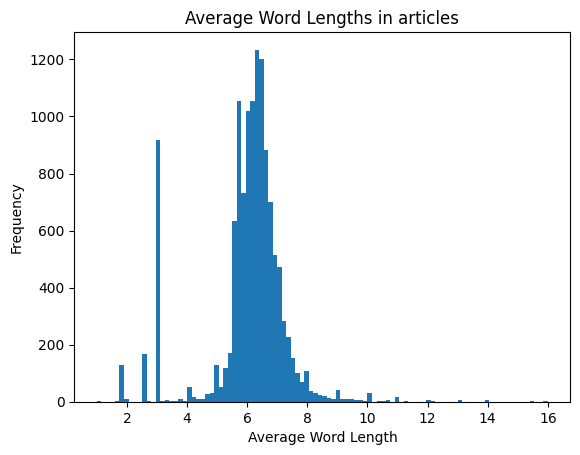

In [6]:
import matplotlib.pyplot as plt

# Print is not very readable, so lets plot it
df["avg_word_len"].plot.hist(bins=100)
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Average Word Lengths in articles')
plt.show()

In [8]:
%%time
# Fast enough
all_words = [word for sublist in df['words'] for word in sublist]

CPU times: user 154 ms, sys: 11.3 ms, total: 165 ms
Wall time: 164 ms


The most frequent words are: [('formula', 11369), ('I', 3881), ('C', 3846), ('II', 3448), ('XIX', 2921), ('XX', 2833), ('III', 1931), ('The', 1579), ('XVIII', 1566), ('XVII', 1139)]


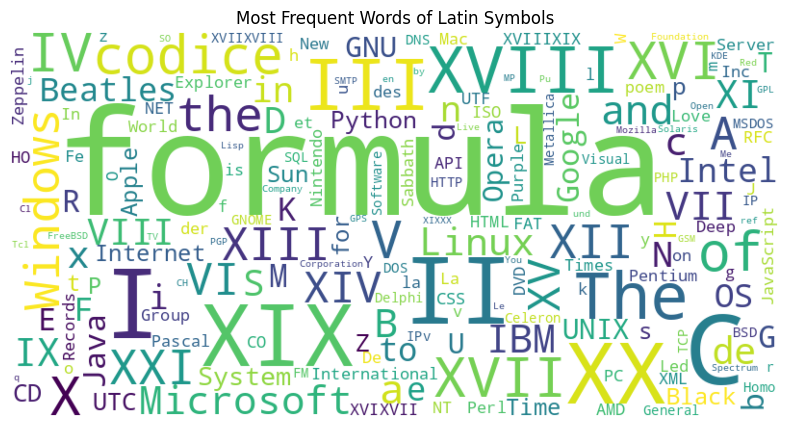

In [9]:
from wordcloud import WordCloud

# Seems like most frequent words are mostly years in roman numerals, I don't know if I should've removed them or not, so I didn't
# 'formula' is #1 which is interesting
english_words = [word for word in all_words if re.match(r'^[a-zA-Z]+$', word)]
english_words_freq = Counter(english_words).most_common()
print(f"The most frequent words are: {english_words_freq[:10]}")

word_freq = dict(english_words_freq)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='hamming')
plt.axis('off')
plt.title('Most Frequent Words of Latin Symbols')
plt.show()

In [65]:
%%time
import numpy as np

@ray.remote
class WordDictionaryActor:
    def __init__(self):
        self.dictionary = {}

    def update_dictionary(self, words):
        for word in words:
            if word.upper() not in self.dictionary:
                self.dictionary[word.upper()] = [0, 0]
            if word[0].isupper():
                self.dictionary[word.upper()][0] += 1
            else:
                self.dictionary[word.upper()][1] += 1

    def get_dictionary(self):
        return self.dictionary

@ray.remote
def process_words(words, word_actor):
    word_actor.update_dictionary.remote(words)

dictionary_actor = WordDictionaryActor.remote()

tasks = []
for split in np.array_split(all_words, 8):
    tasks.append(process_words.remote(split, dictionary_actor))
ray.get(tasks)


# I have a feeling this is not the greatest approach(all those warnings), but cant figure out why yet
final_dictionary = ray.get(dictionary_actor.get_dictionary.remote())

2023-11-14 10:15:09,926	WARNING worker.py:1986 -- Warning: More than 160000 tasks are pending submission to actor 9ab8f81447a22c64aebad88201000000. To reduce memory usage, wait for these tasks to finish before sending more.
(raylet) Spilled 8332 MiB, 31 objects, write throughput 694 MiB/s.


CPU times: user 2.43 s, sys: 719 ms, total: 3.15 s
Wall time: 4.54 s


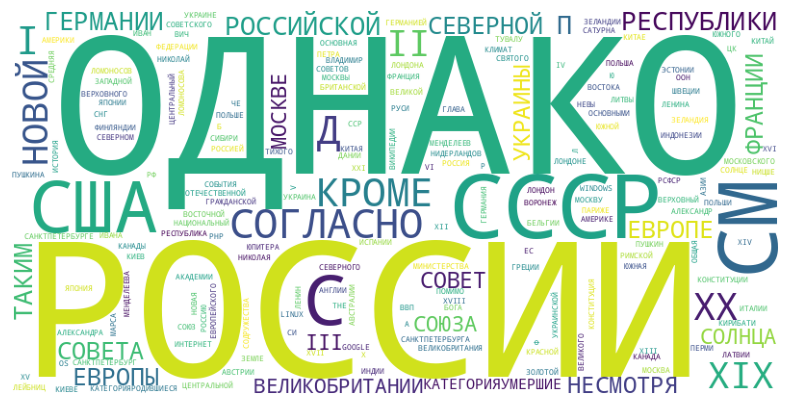

In [66]:
# Apply desired filters
filtered_words = {word: sum(values) for word, values in final_dictionary.items()
                  if sum(values) > 10 and values[0] > values[1]}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
ray.shutdown()
